In [380]:
# import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import inspect
import time

# access parent directory from notebooks directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import src.simulation as s
import src.utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
# Read input variables
input_args = utils.load_input_args('../input/simulation.json')

In [382]:
# instantiate simulation class

simulation =  s.Simulation()

/Users/davidblok/Work EUR/GitHub/ABM-PA/src/simulation.py:23: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.PeerNominatedDataPopulation = p.PeerNominatedDataPopulation('Peer-Nominated data population', self.input_args)
/Users/davidblok/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidblok/Work EUR/GitHub/ABM-PA/src/simulation.py:24: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.CommunicationDataPopulation = p.CommunicationDataPopulation

# Simulation Interventions

## 1. Nomination network

In [384]:
# Read tuned parameter combinations (See tuning_nom_network.ipynb)
pars_nomination = pd.read_csv('../output/opt_pars_nomination.csv', sep=',', header=0)
pars_nomination

,threshold,ipa,error
0,0.025,0.007,0.462071
1,0.025,0.004,0.471020
2,0.025,0.005,0.471045
3,0.025,0.006,0.471688
4,0.025,0.009,0.472211
...,...,...,...
95,0.950,0.005,0.682455
96,1.000,0.045,0.682522
97,1.000,0.038,0.682627
98,1.000,0.042,0.682804


In [385]:
# Run simulations for each parameter combination
list_pre_results_nom = []
list_pre_results_avg_nom = []
list_results_nom = []
list_results_avg_nom = []
list_agents_per_intervention_nom = []
start_whole = time.time()
count = 0
for index, row in pars_nomination.iterrows():
    # run pre-intervention
    pre_results_nom, pre_results_avg_nom, snapshot_pa = simulation.simulate_preinterventions(700, 'nomination', row['threshold'], row['ipa'])
    # run intervention
    results_nom, results_avg_nom, agents_per_intervention_nom = simulation.simulate_interventions(1400, 'nomination', snapshot_pa, row['threshold'], row['ipa'])

    list_pre_results_nom.append(pre_results_nom)
    list_pre_results_avg_nom.append(pre_results_avg_nom)
    list_results_nom.append(results_nom)
    list_results_avg_nom.append(results_avg_nom)
    list_agents_per_intervention_nom.append(agents_per_intervention_nom)
    end = time.time()
    print(count, row['threshold'], row['ipa'], "Time elapsed:", end - start_whole, ' seconds')
    count = count + 1

0 0.025 0.006999999999999999 Time elapsed: 78.00728702545166  seconds
1 0.025 0.004 Time elapsed: 155.013897895813  seconds
2 0.025 0.005 Time elapsed: 231.71023678779602  seconds
3 0.025 0.006 Time elapsed: 308.09709191322327  seconds
4 0.025 0.009000000000000001 Time elapsed: 384.03240275382996  seconds
5 0.025 0.003 Time elapsed: 459.48035979270935  seconds
6 0.025 0.008 Time elapsed: 535.1754479408264  seconds
7 0.025 0.012 Time elapsed: 610.7234079837799  seconds
8 0.025 0.010000000000000002 Time elapsed: 686.7367868423462  seconds
9 0.025 0.011000000000000001 Time elapsed: 762.4967558383942  seconds
10 0.025 0.002 Time elapsed: 840.5293197631836  seconds
11 0.025 0.013 Time elapsed: 916.1774508953094  seconds
12 0.025 0.014000000000000002 Time elapsed: 991.956433057785  seconds
13 0.025 0.015 Time elapsed: 1067.1162428855896  seconds
14 0.05 0.001 Time elapsed: 1142.7747378349304  seconds
15 0.025 0.001 Time elapsed: 1217.5086870193481  seconds
16 0.07500000000000001 0.001 Time e

## 2. Communication network


In [386]:
# Read tuned parameter combinations (See tuning_com_network.ipynb)
pars_communication = pd.read_csv('../output/opt_pars_communication.csv', sep=',', header=0, encoding='latin-1')
pars_communication

,threshold,ipa,error
0,1.000,0.001,0.681127
1,0.975,0.001,0.688750
2,0.950,0.001,0.696958
3,0.925,0.001,0.705704
4,0.900,0.001,0.714352
...,...,...,...
95,0.950,0.013,0.749242
96,0.950,0.018,0.749855
97,0.975,0.032,0.749858
98,1.000,0.048,0.750278


In [433]:
# Run simulations for each parameter combination
list_pre_results_com = []
list_pre_results_avg_com = []
list_results_com = []
list_results_avg_com = []
list_agents_per_intervention_com = []
start_whole = time.time()
count = 0
for index, row in pars_communication.iterrows():
    # run pre-intervention
    pre_results_com, pre_results_avg_com, snapshot_pa = simulation.simulate_preinterventions(700,'communication',row['threshold'],row['ipa'])
    # run intervention
    results_com, results_avg_com, agents_per_intervention_com = simulation.simulate_interventions(1400,'communication',snapshot_pa,row['threshold'],row['ipa'])

    list_pre_results_com.append(pre_results_com)
    list_pre_results_avg_com.append(pre_results_avg_com)
    list_results_com.append(results_com)
    list_results_avg_com.append(results_avg_com)
    list_agents_per_intervention_com.append(agents_per_intervention_com)
    end = time.time()
    print(count, row['threshold'], row['ipa'], "Time elapsed:", end - start_whole, ' seconds')
    count = count + 1


0 1.0 0.001 Time elapsed: 67.74899888038635  seconds
1 0.975 0.001 Time elapsed: 133.9593379497528  seconds
2 0.95 0.001 Time elapsed: 198.38765406608582  seconds
3 0.925 0.001 Time elapsed: 259.68824195861816  seconds
4 0.9 0.001 Time elapsed: 321.8604850769043  seconds
5 1.0 0.002 Time elapsed: 382.568834066391  seconds
6 1.0 0.003 Time elapsed: 444.2329430580139  seconds
7 1.0 0.004 Time elapsed: 508.0634481906891  seconds
8 0.8750000000000001 0.001 Time elapsed: 571.0520141124725  seconds
9 1.0 0.006 Time elapsed: 634.4518101215363  seconds
10 1.0 0.005 Time elapsed: 698.4962191581726  seconds
11 1.0 0.011000000000000001 Time elapsed: 762.1251661777496  seconds
12 1.0 0.010000000000000002 Time elapsed: 825.3437759876251  seconds
13 1.0 0.008 Time elapsed: 888.1909110546112  seconds
14 1.0 0.009000000000000001 Time elapsed: 950.8161568641663  seconds
15 1.0 0.006999999999999999 Time elapsed: 1013.4801399707794  seconds
16 1.0 0.013 Time elapsed: 1076.4182260036469  seconds
17 1.0 0.

# Postprocessing output

In [434]:
# Step 1: reorganizing the data

#####################
## Peer nomination ##
#####################

# pre-intervention
out_preint_nom = []
for run in range(len(list_pre_results_avg_nom)):
    temp_res = []
    for class_id,res in list_pre_results_avg_nom[run].items():
        temp_res.append(pd.DataFrame(list_pre_results_avg_nom[run][class_id]))
    temp = pd.concat(temp_res, axis=1)
    temp.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
    out_preint_nom.append(temp)

# intervention
by_intervention_nom = {}
for i in input_args['intervention_strategy']:
    by_run = []
    for run in range(len(list_results_avg_nom)):
        temp_res = []
        for class_id,res in list_results_avg_nom[run].items():
            temp_res.append(pd.DataFrame(list_results_avg_nom[run][class_id][i]))
        temp = pd.concat(temp_res, axis=1)
        temp.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
        by_run.append(temp)

    by_intervention_nom[i] = by_run

out_noint_nom = by_intervention_nom['nointervention']
out_indegree_nom = by_intervention_nom['indegree']
out_betweenness_nom = by_intervention_nom['closeness']
out_closeness_nom = by_intervention_nom['betweenness']

##########################
## Online communication ##
##########################

# pre-intervention
out_preint_com = []
for run in range(len(list_pre_results_avg_com)):
    temp_res = []
    for class_id,res in list_pre_results_avg_com[run].items():
        temp_res.append(pd.DataFrame(list_pre_results_avg_com[run][class_id]))
    temp = pd.concat(temp_res, axis=1)
    temp.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
    out_preint_com.append(temp)

# intervention
by_intervention_com = {}
for i in input_args['intervention_strategy']:
    by_run = []
    for run in range(len(list_results_avg_com)):
        temp_res = []
        for class_id,res in list_results_avg_com[run].items():
            temp_res.append(pd.DataFrame(list_results_avg_com[run][class_id][i]))
        temp = pd.concat(temp_res, axis=1)
        temp.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
        by_run.append(temp)

    by_intervention_com[i] = by_run

out_noint_com = by_intervention_com['nointervention']
out_indegree_com = by_intervention_com['indegree']
out_betweenness_com = by_intervention_com['closeness']
out_closeness_com = by_intervention_com['betweenness']

In [435]:
# Step 2: calculate overall mean pal per run

#####################
## Peer nomination ##
#####################
by_run_noint = []
by_run_indegree = []
by_run_betweenness = []
by_run_closeness = []
for run in range(len(out_noint_nom)):
    by_run_noint.append(out_noint_nom[run].mean(axis=1))
    by_run_indegree.append(out_indegree_nom[run].mean(axis=1))
    by_run_betweenness.append(out_betweenness_nom[run].mean(axis=1))
    by_run_closeness.append(out_closeness_nom[run].mean(axis=1))

out_tot_noint_nom = pd.concat(by_run_noint, axis =1)
out_tot_indegree_nom = pd.concat(by_run_indegree, axis =1)
out_tot_betweenness_nom = pd.concat(by_run_betweenness, axis =1)
out_tot_closeness_nom = pd.concat(by_run_closeness, axis =1)

##########################
## Online communication ##
##########################
by_run_noint = []
by_run_indegree = []
by_run_betweenness = []
by_run_closeness = []
for run in range(len(out_noint_com)):
    by_run_noint.append(out_noint_com[run].mean(axis=1))
    by_run_indegree.append(out_indegree_com[run].mean(axis=1))
    by_run_betweenness.append(out_betweenness_com[run].mean(axis=1))
    by_run_closeness.append(out_closeness_com[run].mean(axis=1))

out_tot_noint_com = pd.concat(by_run_noint, axis =1)
out_tot_indegree_com = pd.concat(by_run_indegree, axis =1)
out_tot_betweenness_com = pd.concat(by_run_betweenness, axis =1)
out_tot_closeness_com = pd.concat(by_run_closeness, axis =1)

In [436]:
# Step 3 calculate mean, median, 95%CI over 100 runs

#####################
## Peer nomination ##
#####################
# nointervention
n_nom = out_tot_noint_nom.mean(axis=1)
n_nom_med = out_tot_noint_nom.median(axis=1)
n_nom_min = out_tot_noint_nom.quantile(q=0.025, axis=1)
n_nom_max = out_tot_noint_nom.quantile(q=0.975, axis=1)

# indegree
i_nom = out_tot_indegree_nom.mean(axis=1)
i_nom_med = out_tot_indegree_nom.median(axis=1)
i_nom_min = out_tot_indegree_nom.quantile(q=0.025, axis=1)
i_nom_max = out_tot_indegree_nom.quantile(q=0.975, axis=1)

# betweenness
b_nom = out_tot_betweenness_nom.mean(axis=1)
b_nom_med = out_tot_betweenness_nom.median(axis=1)
b_nom_min = out_tot_betweenness_nom.quantile(q=0.025, axis=1)
b_nom_max = out_tot_betweenness_nom.quantile(q=0.975, axis=1)

# closeness
c_nom = out_tot_closeness_nom.mean(axis=1)
c_nom_med = out_tot_closeness_nom.median(axis=1)
c_nom_min = out_tot_closeness_nom.quantile(q=0.025, axis=1)
c_nom_max = out_tot_closeness_nom.quantile(q=0.975, axis=1)

##########################
## Online communication ##
##########################
# nointervention
n_com = out_tot_noint_com.mean(axis=1)
n_com_med = out_tot_noint_com.median(axis=1)
n_com_min = out_tot_noint_com.quantile(q=0.025, axis=1)
n_com_max = out_tot_noint_com.quantile(q=0.975, axis=1)

# indegree
i_com = out_tot_indegree_com.mean(axis=1)
i_com_med = out_tot_indegree_com.median(axis=1)
i_com_min = out_tot_indegree_com.quantile(q=0.025, axis=1)
i_com_max = out_tot_indegree_com.quantile(q=0.975, axis=1)

# betweenness
b_com = out_tot_betweenness_com.mean(axis=1)
b_com_med = out_tot_betweenness_com.median(axis=1)
b_com_min = out_tot_betweenness_com.quantile(q=0.025, axis=1)
b_com_max = out_tot_betweenness_com.quantile(q=0.975, axis=1)

# closeness
c_com = out_tot_closeness_com.mean(axis=1)
c_com_med = out_tot_closeness_com.median(axis=1)
c_com_min = out_tot_closeness_com.quantile(q=0.025, axis=1)
c_com_max = out_tot_closeness_com.quantile(q=0.975, axis=1)


In [438]:
# Impact on PAL: % change (mean, median, min, max)

#####################
## Peer nomination ##
#####################
n_nom_sr = (n_nom/n_nom[0] -1) *100
n_nom_sr_med = (n_nom_med/n_nom_med[0] -1) *100
n_nom_sr_min = (n_nom_min/n_nom_min[0] -1) *100
n_nom_sr_max = (n_nom_max/n_nom_max[0] -1) *100
i_nom_sr = (i_nom/i_nom[0] -1) *100
i_nom_sr_med = (i_nom_med/i_nom_med[0] -1) *100
i_nom_sr_min = (i_nom_min/i_nom_min[0] -1) *100
i_nom_sr_max = (i_nom_max/i_nom_max[0] -1) *100
b_nom_sr = (b_nom/b_nom[0] -1) *100
b_nom_sr_med = (b_nom_med/b_nom_med[0] -1) *100
b_nom_sr_min = (b_nom_min/b_nom_min[0] -1) *100
b_nom_sr_max = (b_nom_max/b_nom_max[0] -1) *100
c_nom_sr = (c_nom/c_nom[0] -1) *100
c_nom_sr_med = (c_nom_med/c_nom_med[0] -1) *100
c_nom_sr_min = (c_nom_min/c_nom_min[0] -1) *100
c_nom_sr_max = (c_nom_max/c_nom_max[0] -1) *100

# mean and confidence intervals at day 700
print('nom nointervention: mean =', n_nom_sr[699], '(95%CI =', n_nom_sr_min[699], ',', n_nom_sr_max[699], ')')
print('nom indegree: mean =', i_nom_sr[699], '(95%CI =', i_nom_sr_min[699], ',', i_nom_sr_max[699], ')')
print('nom betweenness: mean =', b_nom_sr[699], '(95%CI =', b_nom_sr_min[699], ',', b_nom_sr_max[699], ')')
print('nom closeness: mean =', c_nom_sr[699], '(95%CI =', c_nom_sr_min[699], ',', c_nom_sr_max[699], ')')

##########################
## Online communication ##
##########################
n_com_sr = (n_com/n_com[0] -1) *100
n_com_sr_med = (n_com_med/n_com_med[0] -1) *100
n_com_sr_min = (n_com_min/n_com_min[0] -1) *100
n_com_sr_max = (n_com_max/n_com_max[0] -1) *100
i_com_sr = (i_com/i_com[0] -1) *100
i_com_sr_med = (i_com_med/i_com_med[0] -1) *100
i_com_sr_min = (i_com_min/i_com_min[0] -1) *100
i_com_sr_max = (i_com_max/i_com_max[0] -1) *100
b_com_sr = (b_com/b_com[0] -1) *100
b_com_sr_med = (b_com_med/b_com_med[0] -1) *100
b_com_sr_min = (b_com_min/b_com_min[0] -1) *100
b_com_sr_max = (b_com_max/b_com_max[0] -1) *100
c_com_sr = (c_com/c_com[0] -1) *100
c_com_sr_med = (c_com_med/c_com_med[0] -1) *100
c_com_sr_min = (c_com_min/c_com_min[0] -1) *100
c_com_sr_max = (c_com_max/c_com_max[0] -1) *100

# mean and confidence intervals at day 700
print('com nointervention: mean =', n_com_sr[699], '(95%CI =', n_com_sr_min[699], ',', n_com_sr_max[699], ')')
print('com indegree: mean =', i_com_sr[699], '(95%CI =', i_com_sr_min[699], ',', i_com_sr_max[699], ')')
print('com betweenness: mean =', b_com_sr[699], '(95%CI =', b_com_sr_min[699], ',', b_com_sr_max[699], ')')
print('com closeness: mean =', c_com_sr[699], '(95%CI =', c_com_sr_min[699], ',', c_com_sr_max[699], ')')

nom nointervention: mean = 0.0 (95%CI = 0.0 , 0.0 )
nom indegree: mean = 3.3445163028019698 (95%CI = 0.025118069450846825 , 8.063863321906073 )
nom betweenness: mean = 2.7841910422750527 (95%CI = 0.018289166797003098 , 8.064048086890384 )
nom closeness: mean = 1.7053452305721972 (95%CI = 0.0034231633157189023 , 6.524706791195478 )
com nointervention: mean = 0.0 (95%CI = 0.0 , 0.0 )
com indegree: mean = 1.1266832842874441 (95%CI = 0.8874243736995746 , 1.4369808310550791 )
com betweenness: mean = 1.1209917160783789 (95%CI = 0.8850117091253384 , 1.4516858841515434 )
com closeness: mean = 1.1443418773153358 (95%CI = 0.9048838070155885 , 1.464258332077173 )


# Ploting the outcomes

## 1. PAL

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


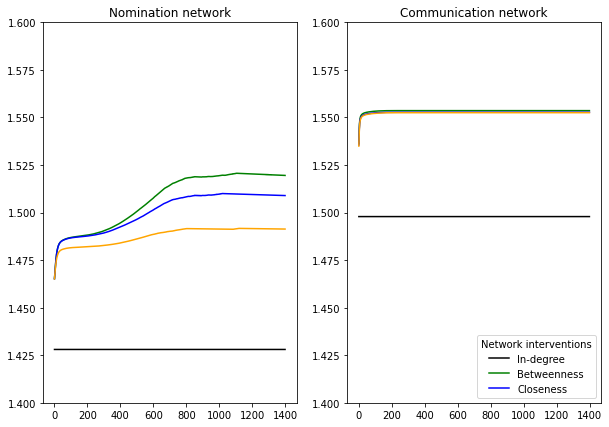

In [439]:
# Plots (with confidence intervals)
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0,1400,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))

ax1.set_title('Nomination network')
ax1.set_ylim([1.4, 1.6])
ax1.plot(x, n_nom, color='black')
ax1.plot(x, i_nom, color='green')
#plt.fill_between(x, i_nom_min, i_nom_max, alpha=0.2, color='C5')
ax1.plot(x, b_nom, color='blue')
#plt.fill_between(x, b_nom_min, b_nom_max, alpha=0.2, color='C0')
ax1.plot(x, c_nom, color='orange')
#plt.fill_between(x, c_nom_min, c_nom_max, alpha=0.2, color='C3')

ax2.set_title('Communication network')
ax2.set_ylim([1.4, 1.6])
ax2.plot(x, n_com, color='black')
ax2.plot(x, i_com, color='green')
#plt.fill_between(x, i_com_min, i_com_max, alpha=0.2, color='C5')
ax2.plot(x, b_com, color='blue')
#plt.fill_between(x, b_com_min, b_com_max, alpha=0.2, color='C0')
ax2.plot(x, c_com, color='orange')
#plt.fill_between(x, c_com_min, c_com_max, alpha=0.2, color='C3')
ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

fig.savefig('../output/sim_results1.eps', bbox_inches='tight', format='eps', dpi=1000)

## 2. Impact on PAL: success rate (used in paper)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


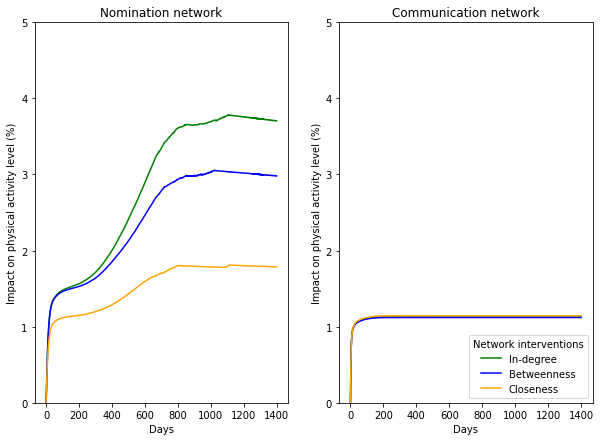

In [440]:
# Plot (without confidence intervals): used in paper
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0,1400,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))

ax1.set_title('Nomination network')
ax1.set_xlabel('Days')
ax1.set_ylabel('Impact on physical activity level (%)')
ax1.set_ylim([0, 5])
ax1.plot(x, i_nom_sr, color='green')
ax1.plot(x, b_nom_sr, color='blue')
ax1.plot(x, c_nom_sr, color='orange')

ax2.set_title('Communication network')
ax2.set_xlabel('Days')
ax2.set_ylabel('Impact on physical activity level (%)')
ax2.set_ylim([0, 5])
ax2.plot(x, i_com_sr, color='green')
ax2.plot(x, b_com_sr, color='blue')
ax2.plot(x, c_com_sr, color='orange')
ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

fig.savefig('../output/sim_results2.eps', bbox_inches='tight', format='eps', dpi=1000)


## 3. Variation between classes (used in paper)

In [ ]:
# Nomination network
all_averaged_nomm = {}
for class_id in input_args['classes']:
    all_averaged_nomm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_nom:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_nomm[str(class_id)][i] = temp_res/count_res

# Communication network
all_averaged_comm = {}
for class_id in input_args['classes']:
    all_averaged_comm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_com:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_comm[str(class_id)][i] = temp_res/count_res

In [443]:

# Nomination network
class_indegree_nom = []
class_betweenness_nom = []
class_closeness_nom = []

for c in input_args['classes']:
    # per run
    temp1 = all_averaged_nomm[str(c)]
    class_indegree_nom.append(temp1['indegree'])
    class_betweenness_nom.append(temp1['betweenness'])
    class_closeness_nom.append(temp1['closeness'])

# Communication network
class_indegree_com = []
class_betweenness_com = []
class_closeness_com = []

for c in input_args['classes']:
    # per run
    temp1 = all_averaged_comm[str(c)]
    class_indegree_com.append(temp1['indegree'])
    class_betweenness_com.append(temp1['betweenness'])
    class_closeness_com.append(temp1['closeness'])

In [444]:
# Nomination network
pd_class_indegree_nom = pd.concat(class_indegree_nom, axis=1, keys=[s.name for s in class_indegree_nom])
pd_class_betweenness_nom = pd.concat(class_betweenness_nom, axis=1, keys=[s.name for s in class_betweenness_nom])
pd_class_closeness_nom = pd.concat(class_closeness_nom, axis=1, keys=[s.name for s in class_closeness_nom])

# Comunication network
pd_class_indegree_com = pd.concat(class_indegree_com, axis=1, keys=[s.name for s in class_indegree_com])
pd_class_betweenness_com = pd.concat(class_betweenness_com, axis=1, keys=[s.name for s in class_betweenness_com])
pd_class_closeness_com = pd.concat(class_closeness_com, axis=1, keys=[s.name for s in class_closeness_com])


nom_clvar = {'In-degree': (pd_class_indegree_nom.iloc[699]/pd_class_indegree_nom.iloc[0] -1) *100,
           'Betweenness': (pd_class_betweenness_nom.iloc[699]/pd_class_betweenness_nom.iloc[0] -1) *100,
           'Closeness': (pd_class_closeness_nom.iloc[699]/pd_class_closeness_nom.iloc[0] -1) *100}

com_clvar = {'In-degree': (pd_class_indegree_com.iloc[699]/pd_class_indegree_com.iloc[0] -1) *100,
           'Betweenness': (pd_class_betweenness_com.iloc[699]/pd_class_betweenness_com.iloc[0] -1) *100,
           'Closeness': (pd_class_closeness_com.iloc[699]/pd_class_closeness_com.iloc[0] -1) *100}



In [445]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Nomination network')
ax1.set_ylabel('Impact on phyisical activity level (%)')
ax1.set_ylim([0, 18])
ax1.boxplot(nom_clvar.values())
ax1.set_xticklabels(nom_clvar.keys())


ax2.set_title('Communication network')
ax2.set_ylabel('Impact on phyisical activity level (%)')
ax2.set_ylim([0, 18])
ax2.boxplot(com_clvar.values())
ax2.set_xticklabels(com_clvar.keys())
#ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")


fig.savefig('../output/sim_results4.eps', bbox_inches='tight', format='eps', dpi=1000)



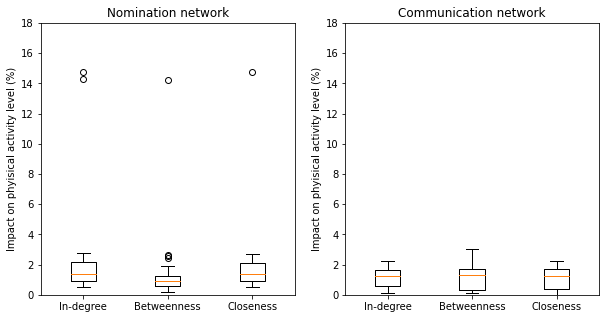

In [446]:
i_nom_bp = (pd_class_indegree_nom.iloc[699]/pd_class_indegree_nom.iloc[0] -1) *100
b_nom_bp = (pd_class_betweenness_nom.iloc[699]/pd_class_betweenness_nom.iloc[0] -1) *100
c_nom_bp =  (pd_class_closeness_nom.iloc[699]/pd_class_closeness_nom.iloc[0] -1) *100

i_com_bp = (pd_class_indegree_com.iloc[699]/pd_class_indegree_com.iloc[0] -1) *100
b_com_bp = (pd_class_betweenness_com.iloc[699]/pd_class_betweenness_com.iloc[0] -1) *100
c_com_bp = (pd_class_closeness_com.iloc[699]/pd_class_closeness_com.iloc[0] -1) *100

In [421]:
com_clvar


In [422]:
nom_clvar

{'Betweenness': NaN    2.018263
 NaN    1.149714
 NaN    1.450441
 NaN    2.325866
 NaN    2.459694
 NaN    0.327137
 NaN    2.167329
 NaN    1.798392
 NaN    0.239212
 NaN    0.189291
 NaN    0.416111
 NaN    1.611034
 NaN    0.860941
 NaN    0.625929
 NaN    3.202862
 NaN    0.339296
 NaN    1.483267
 NaN    0.944469
 NaN    1.403990
 NaN    0.309719
 NaN    1.574082
 dtype: float64, 'Closeness': NaN    2.018263
 NaN    1.279323
 NaN    2.029135
 NaN    0.339873
 NaN    2.459694
 NaN    0.188994
 NaN    2.167329
 NaN    2.148562
 NaN    0.645744
 NaN    1.825450
 NaN    0.356728
 NaN    2.331192
 NaN    0.860941
 NaN    1.140219
 NaN    0.064845
 NaN    0.407421
 NaN    1.427285
 NaN    1.663160
 NaN    0.647741
 NaN    0.508605
 NaN    1.675290
 dtype: float64, 'In-degree': NaN    2.233560
 NaN    1.279323
 NaN    0.664483
 NaN    1.255904
 NaN    2.459694
 NaN    0.174425
 NaN    2.167329
 NaN    1.823299
 NaN    0.645744
 NaN    1.825450
 NaN    0.356728
 NaN    2.143782
 NaN    0

## 4. Variation between runs (day 700)

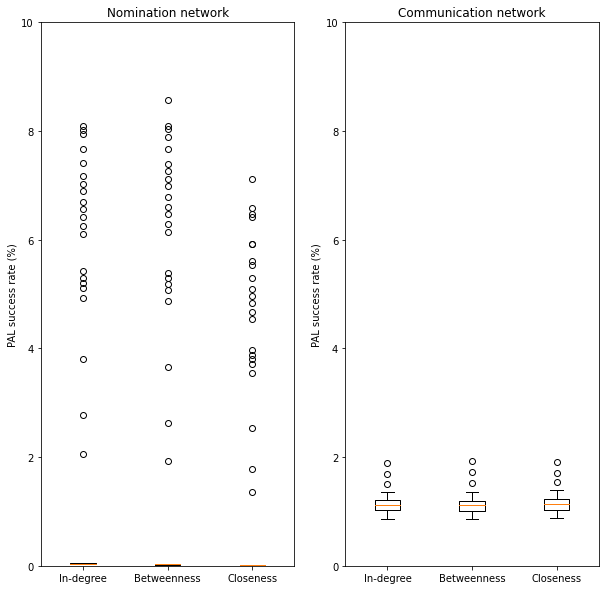

In [447]:
nom_var = {'In-degree': (out_tot_indegree_nom.iloc[699]/out_tot_indegree_nom.iloc[0] -1) *100,
           'Betweenness': (out_tot_betweenness_nom.iloc[699]/out_tot_betweenness_nom.iloc[0] -1) *100,
           'Closeness': (out_tot_closeness_nom.iloc[699]/out_tot_closeness_nom.iloc[0] -1) *100}

com_var = {'In-degree': (out_tot_indegree_com.iloc[699]/out_tot_indegree_com.iloc[0] -1) *100,
           'Betweenness': (out_tot_betweenness_com.iloc[699]/out_tot_betweenness_com.iloc[0] -1) *100,
           'Closeness': (out_tot_closeness_com.iloc[699]/out_tot_closeness_com.iloc[0] -1) *100}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.set_title('Nomination network')
ax1.set_ylabel('PAL success rate (%)')
ax1.set_ylim([0,10])
ax1.boxplot(nom_var.values())
ax1.set_xticklabels(nom_var.keys())


ax2.set_title('Communication network')
ax2.set_ylabel('PAL success rate (%)')
ax2.set_ylim([0, 10])
ax2.boxplot(com_var.values())
ax2.set_xticklabels(com_var.keys())
#ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

fig.savefig('../output/sim_results3.eps', bbox_inches='tight', format='eps', dpi=1000)